In [42]:
from sympl import TimeDifferencingWrapper, NetCDFMonitor, PlotFunctionMonitor, DataArray
import climt
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr
from tqdm import tqdm_notebook as tqdm

In [36]:
def plot_function(fig, state):

    ax = fig.add_subplot(2, 2, 1)
    state['specific_humidity'].mean(
        dim='lon').plot.contourf(
            ax=ax, levels=16, robust=True)
    ax.set_title('Specific Humidity')

    ax = fig.add_subplot(2, 2, 3)
    state['eastward_wind'].mean(dim='lon').plot.contourf(
        ax=ax, levels=16, robust=True)
    ax.set_title('Zonal Wind')

    ax = fig.add_subplot(2, 2, 2)
    state['air_temperature_tendency_from_convection'].transpose().mean(
        dim='lon').plot.contourf(
        ax=ax, levels=16, robust=True)
    ax.set_title('Conv. Heating Rate')

    ax = fig.add_subplot(2, 2, 4)
    state['air_temperature'].mean(dim='lon').plot.contourf(
        ax=ax, levels=16)
    ax.set_title('Temperature')

    fig.tight_layout()

In [58]:
monitor = PlotFunctionMonitor(plot_function)

climt.set_constants_from_dict({
    'stellar_irradiance': {'value': 200, 'units': 'W m^-2'}})

model_time_step = timedelta(seconds=600)

# Create components
convection = climt.EmanuelConvection()
simple_physics = TimeDifferencingWrapper(climt.SimplePhysics())

radiation = climt.GrayLongwaveRadiation()
slab_surface = climt.SlabSurface()

dycore = climt.GFSDynamicalCore(
    [simple_physics, radiation, slab_surface,
     convection], number_of_damped_levels=5
)
grid = climt.get_grid(nx=128, ny=62)

# Create model state
my_state = climt.get_default_state([dycore], grid_state=grid)

# Set initial/boundary conditions
latitudes = my_state['latitude'].values
longitudes = my_state['longitude'].values

surface_shape = latitudes.shape

# Set initial/boundary conditions
sw_flux_equator = 300
sw_flux_pole = 0

sw_flux_profile = sw_flux_equator - (
    (sw_flux_equator - sw_flux_pole)*(np.sin(np.radians(latitudes))**2))

my_state['downwelling_shortwave_flux_in_air'].values[:] = sw_flux_profile[np.newaxis, :]
my_state['surface_temperature'].values[:] = 290.
my_state['ocean_mixed_layer_thickness'].values[:] = 5

my_state['eastward_wind'].values[:] = np.random.randn(
    *my_state['eastward_wind'].shape)

<Figure size 432x288 with 0 Axes>

/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/site-packages/sympl/_core/tracers.py:202: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  array[tracer_slice] = raw_state[name]
/home/s/S.Rasp/miniconda3/envs/tf/lib/python3.6/site-packages/sympl/_core/tracers.py:229: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  raw_state[name] = tracer_array[tracer_slice]


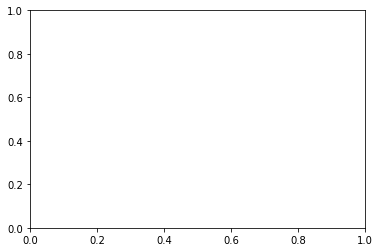

In [59]:
for i in tqdm(range(50)):
    diag, my_state = dycore(my_state, model_time_step)
    my_state.update(diag)
    my_state['time'] += model_time_step

    if i % 6 == 0:
        monitor.store(my_state)

    #print(my_state['time'])

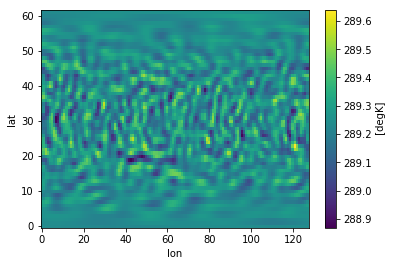

In [60]:
my_state['air_temperature'].isel(mid_levels=15).plot()

In [61]:
my_state.keys()

dict_keys(['specific_humidity', 'air_temperature', 'air_pressure', 'air_pressure_on_interface_levels', 'surface_air_pressure', 'eastward_wind', 'northward_wind', 'divergence_of_wind', 'atmosphere_relative_vorticity', 'surface_temperature', 'atmosphere_hybrid_sigma_pressure_a_coordinate_on_interface_levels', 'atmosphere_hybrid_sigma_pressure_b_coordinate_on_interface_levels', 'time', 'longitude', 'latitude', 'height_on_ice_interface_levels', 'surface_geopotential', 'surface_specific_humidity', 'longwave_optical_depth_on_interface_levels', 'downwelling_longwave_flux_in_air', 'downwelling_shortwave_flux_in_air', 'upwelling_longwave_flux_in_air', 'upwelling_shortwave_flux_in_air', 'surface_upward_latent_heat_flux', 'surface_upward_sensible_heat_flux', 'surface_thermal_capacity', 'surface_material_density', 'upward_heat_flux_at_ground_level_in_soil', 'heat_flux_into_sea_water_due_to_sea_ice', 'area_type', 'soil_layer_thickness', 'ocean_mixed_layer_thickness', 'heat_capacity_of_soil', 'sea_w

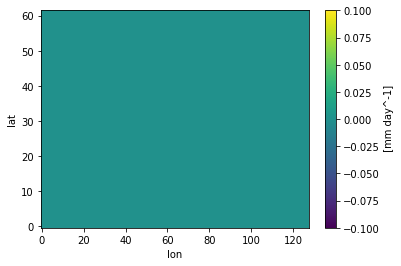

In [62]:
my_state['convective_precipitation_rate'].plot()